# Example for ACE.

In [1]:
import sys
sys.path.append('..')

### Data preparation

In [2]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

In [3]:
feature_names = {0: 'Sepal Length', 1: 'Sepal Width', 2: 'Petal Length', 3: 'Petal Width'}
class_names = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
n_feats = len(feature_names)
n_classes = len(class_names)
x, y = load_iris(return_X_y=True, as_frame=True)

In [4]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

### Fit a predictor.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class MLP(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self._layer1 = nn.Linear(input_dim, 128)
        self._output = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.tanh(self._layer1(x))
        return self._output(x)

In [7]:
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)
dataset = torch.utils.data.TensorDataset(x, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
model = MLP(n_feats, n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    for batch_x, batch_y in dataloader:
        batch_pred = model(batch_x)
        loss = F.cross_entropy(batch_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch + 1} / 100, Loss: {loss:.3f}')

Epoch 1 / 100, Loss: 1.104
Epoch 1 / 100, Loss: 1.139
Epoch 1 / 100, Loss: 1.088
Epoch 1 / 100, Loss: 1.050
Epoch 1 / 100, Loss: 1.048
Epoch 2 / 100, Loss: 1.047
Epoch 2 / 100, Loss: 1.019
Epoch 2 / 100, Loss: 1.050
Epoch 2 / 100, Loss: 1.005
Epoch 2 / 100, Loss: 1.012
Epoch 3 / 100, Loss: 1.001
Epoch 3 / 100, Loss: 1.029
Epoch 3 / 100, Loss: 0.964
Epoch 3 / 100, Loss: 0.960
Epoch 3 / 100, Loss: 0.930
Epoch 4 / 100, Loss: 0.936
Epoch 4 / 100, Loss: 0.945
Epoch 4 / 100, Loss: 0.944
Epoch 4 / 100, Loss: 0.904
Epoch 4 / 100, Loss: 0.932
Epoch 5 / 100, Loss: 0.928
Epoch 5 / 100, Loss: 0.906
Epoch 5 / 100, Loss: 0.884
Epoch 5 / 100, Loss: 0.877
Epoch 5 / 100, Loss: 0.843
Epoch 6 / 100, Loss: 0.898
Epoch 6 / 100, Loss: 0.841
Epoch 6 / 100, Loss: 0.832
Epoch 6 / 100, Loss: 0.835
Epoch 6 / 100, Loss: 0.844
Epoch 7 / 100, Loss: 0.803
Epoch 7 / 100, Loss: 0.821
Epoch 7 / 100, Loss: 0.844
Epoch 7 / 100, Loss: 0.783
Epoch 7 / 100, Loss: 0.826
Epoch 8 / 100, Loss: 0.827
Epoch 8 / 100, Loss: 0.738
E

### Get estimated causal effects.

In [9]:
import numpy as np
from causal.effect import ACE
x = x.detach().cpu().numpy()
ace = ACE(model, 'classification')
causal_effect = ace.predict(x, 0, 0, 0.1)  # get the causal effect of do(alpha=0.01 | x) on feature 0 and class 0.
print(causal_effect)

1.171624545720889


In [10]:
causal_effects = []
for class_idx in range(n_classes):
    for feature_idx in range(n_feats):
        # get causal effects over whole feature space.
        causal_effects.append([ace.predict(x, feature_idx, class_idx, alpha) for alpha in np.linspace(x[:, feature_idx].min(), x[:, feature_idx].max(), 1000)])
causal_effects = np.array(causal_effects)
causal_effects = causal_effects.reshape(n_classes, n_feats, -1)
print(causal_effects.shape)

(3, 4, 1000)


### Visualization

In [11]:
import matplotlib.pyplot as plt
import numpy as np

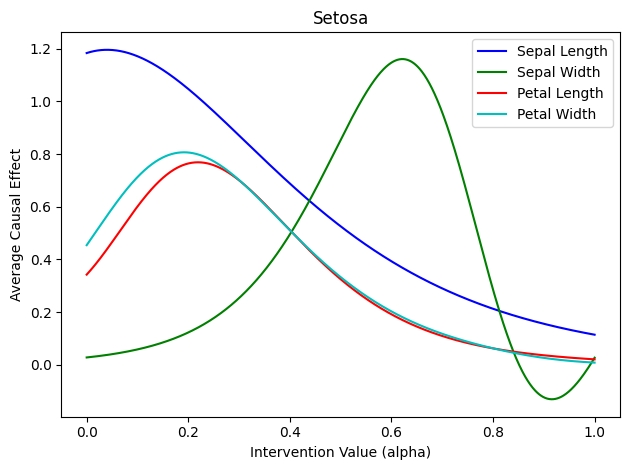

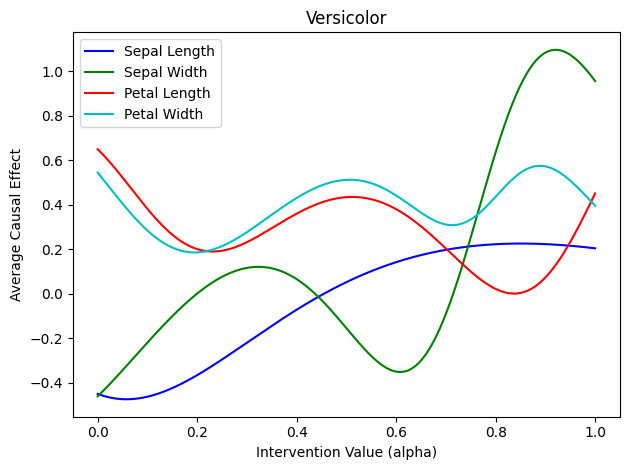

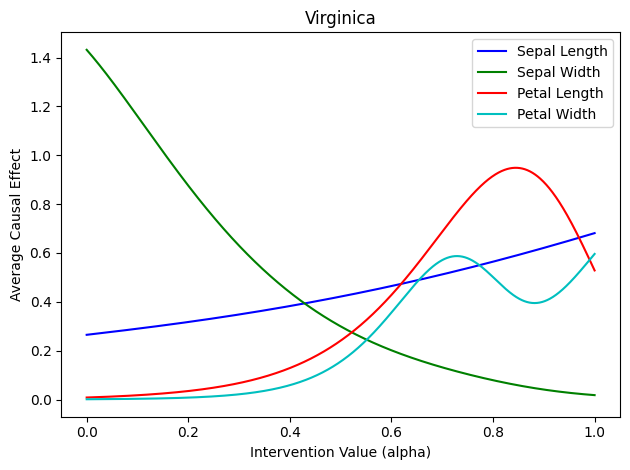

<Figure size 640x480 with 0 Axes>

In [12]:
color = {0: 'b', 1: 'g', 2: 'r', 3: 'c'}
for class_idx in range(n_classes):
    for feature_idx in range(n_feats):
        a = np.linspace(x[:, feature_idx].min(), x[:, feature_idx].max(), 1000)
        b = causal_effects[class_idx, feature_idx]
        plt.plot(a, b, label=feature_names[feature_idx], color=color[feature_idx])
    plt.title(class_names[class_idx])
    plt.xlabel('Intervention Value (alpha)')
    plt.ylabel('Average Causal Effect')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.clf()